In [1]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
from wordcloud import WordCloud
import numpy as np
import umap
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display


In [2]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt_tab: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [3]:
# Load the original dataset
file_path = "News_Category_Dataset_v3.json"  # Update with actual path
df = pd.read_json(file_path, lines=True)

# Data Cleaning and Preprocessing
print(f"Number of rows in original dataset: {df.shape[0]}")
print(f"Number of columns in original dataset: {df.shape[1]}")
display(df.head())

df = df.applymap(lambda x: None if isinstance(x, str) and x.strip() == '' else x.strip() if isinstance(x, str) else x)
print(f"Null values in each column:\n{df.isnull().sum()}")
print(f"Number of duplicated rows: {df.duplicated().sum()}")

df = df.dropna(subset=['headline', 'short_description'])
df = df.drop_duplicates()
df = df[df['date'].dt.year.isin(range(2017, 2023))]
print(f"Number of rows after cleaning: {df.shape[0]}")
print(f"Number of columns after cleaning: {df.shape[1]}")

df['text'] = df[['headline', 'short_description']].astype(str).apply(lambda x: ' '.join(x), axis=1)

Number of rows in original dataset: 209527
Number of columns in original dataset: 6


link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when he ...        Mary Papenfuss   
2  "Until you have a dog you don't understand wha...         Elyse Wanshel   
3  "Accidentally put grown-up toothpaste on my to...      Caroline Bologna   
4  Amy Cooper accused investment firm Franklin Te...        Nina Golgowski   

        date  
0 2022-09-23  
1 2022-09-23  
2 2022-09-23  
3 2022-09-23  
4 2022-09-22

C:\Users\Ella\AppData\Local\Temp\ipykernel_7432\1545133483.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: None if isinstance(x, str) and x.strip() == '' else x.strip() if isinstance(x, str) else x)


Null values in each column:
link                     0
headline                 6
category                 0
short_description    19712
authors              37418
date                     0
dtype: int64
Number of duplicated rows: 13
Number of rows after cleaning: 47010
Number of columns after cleaning: 6


In [4]:
# Text Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation & numbers
    text = re.sub(r'\btrump\b', '', text)  # Remove "trump"
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['processed_text'] = df['text'].apply(preprocess_text)

In [5]:
# Tokenization, Stopword Removal, and Lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text) if word not in stop_words])

df['filtered_text'] = df['processed_text'].apply(tokenize_and_lemmatize)

In [6]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=6000, stop_words='english', max_df=0.5, min_df=5, ngram_range=(1,2))
X = vectorizer.fit_transform(df['filtered_text'])


In [7]:
# Dimensionality Reduction
svd = TruncatedSVD(n_components=min(X.shape[1], 3800), random_state=42)
X_svd = svd.fit_transform(X).astype(np.float32)

explained_variance = svd.explained_variance_ratio_.sum()
print(f"Total explained variance by selected components: {explained_variance:.4f}")

Total explained variance by selected components: 0.9025


In [8]:
# UMAP for further dimensionality reduction
umap_model = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.3, random_state=42)
X_umap = umap_model.fit_transform(X_svd)


c:\Users\Ella\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Ella\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [9]:
# Normalize data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_umap)

In [10]:

# Perform Clustering using Gaussian Mixture Model for k = 2 to 20
bic_scores = []
aic_scores = []
silhouette_scores = []
k_values = list(range(2, 21))

gmm_models = {}
gmm_labels = {}

def compute_silhouette(X, labels):
    try:
        return silhouette_score(X, labels)
    except:
        return np.nan

for k in k_values:
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels = gmm.fit_predict(X_normalized)
    gmm_models[k] = gmm
    gmm_labels[k] = labels
    bic_scores.append(gmm.bic(X_normalized))
    aic_scores.append(gmm.aic(X_normalized))
    silhouette_scores.append(compute_silhouette(X_normalized, labels))

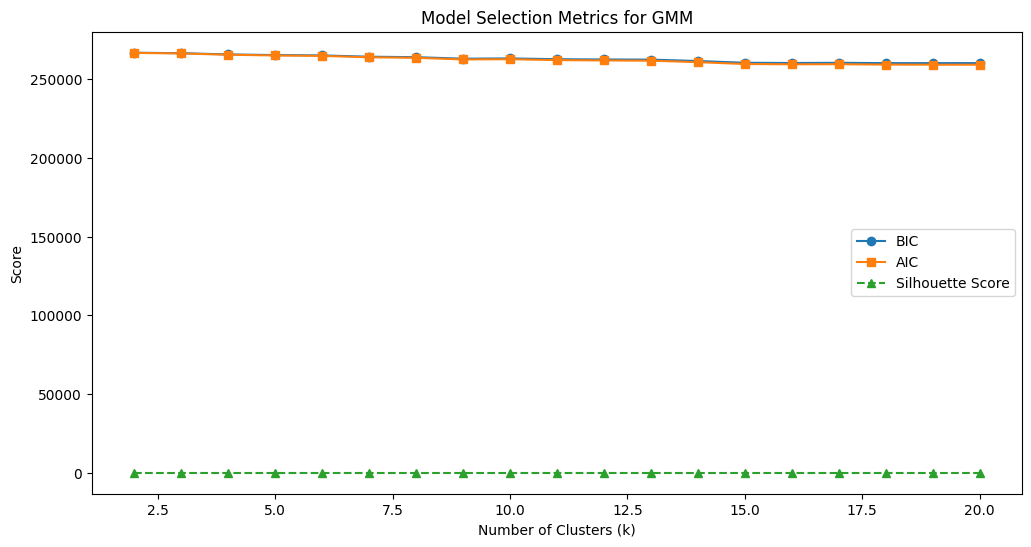

Optimal number of clusters based on BIC: 19


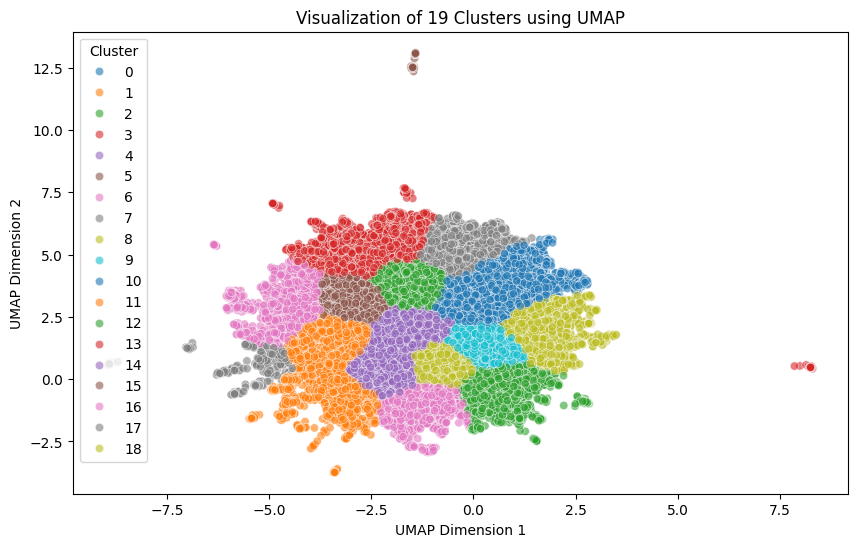

In [11]:
# Plot BIC, AIC, and Silhouette Scores
plt.figure(figsize=(12, 6))
plt.plot(k_values, bic_scores, marker='o', label='BIC')
plt.plot(k_values, aic_scores, marker='s', label='AIC')
plt.plot(k_values, silhouette_scores, marker='^', label='Silhouette Score', linestyle='dashed')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score')
plt.title('Model Selection Metrics for GMM')
plt.legend()
plt.show()

# Selecting the best k based on BIC
best_k = k_values[np.argmin(bic_scores)]
print(f'Optimal number of clusters based on BIC: {best_k}')

# Visualizing the best clustering result
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=gmm_labels[best_k], palette='tab10', alpha=0.6)
plt.title(f'Visualization of {best_k} Clusters using UMAP')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Cluster')
plt.show()

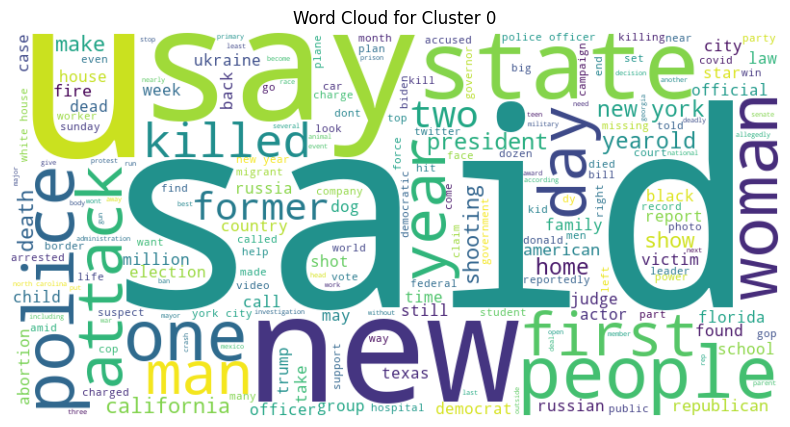

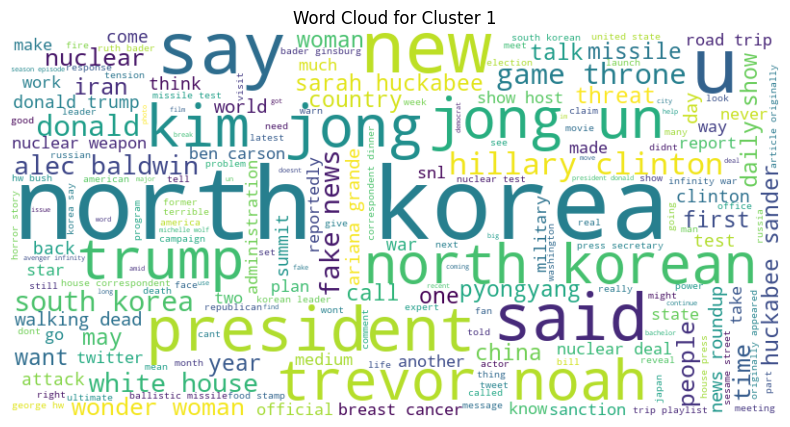

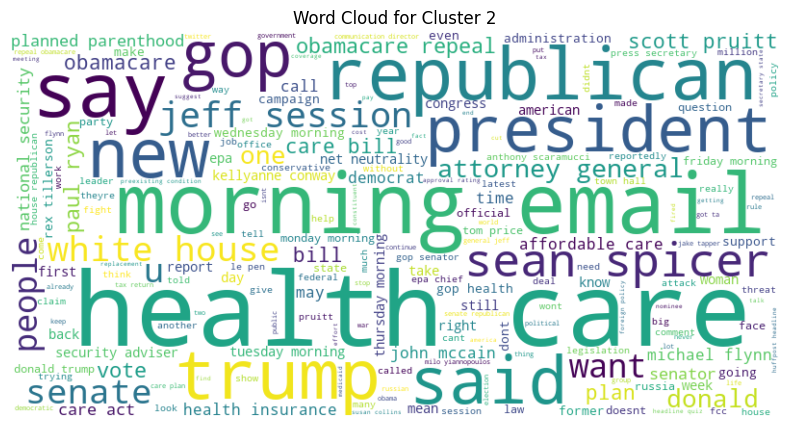

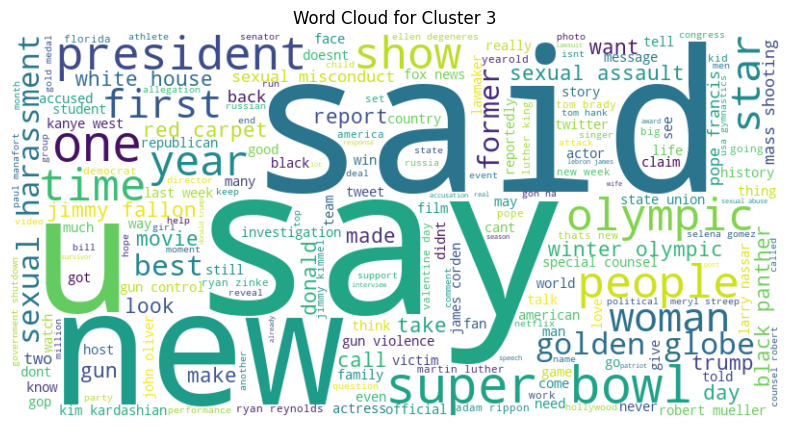

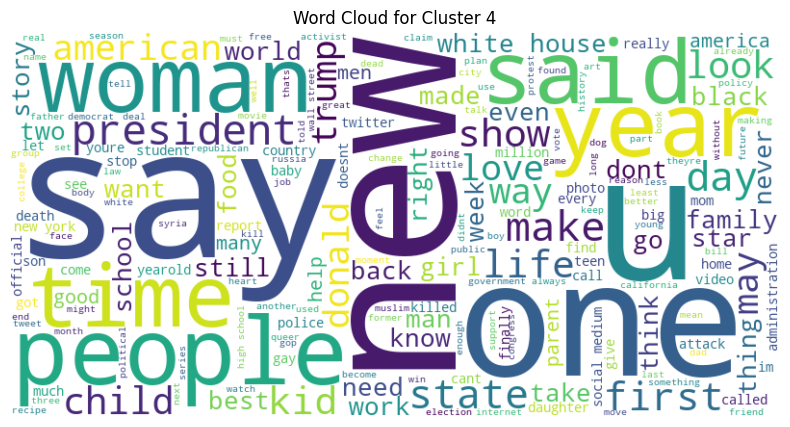

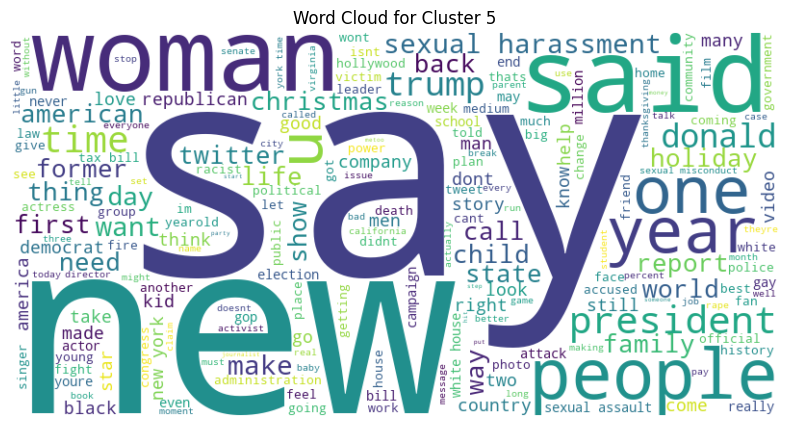

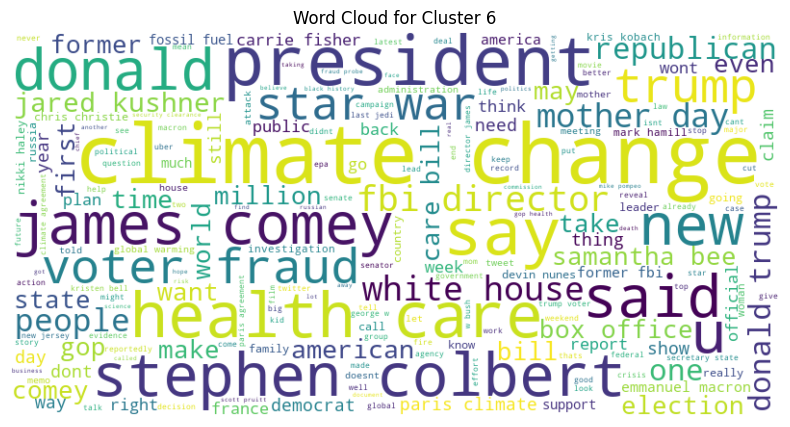

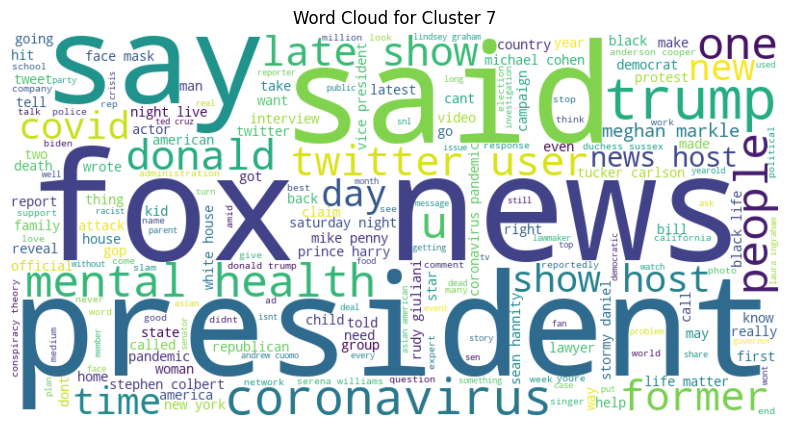

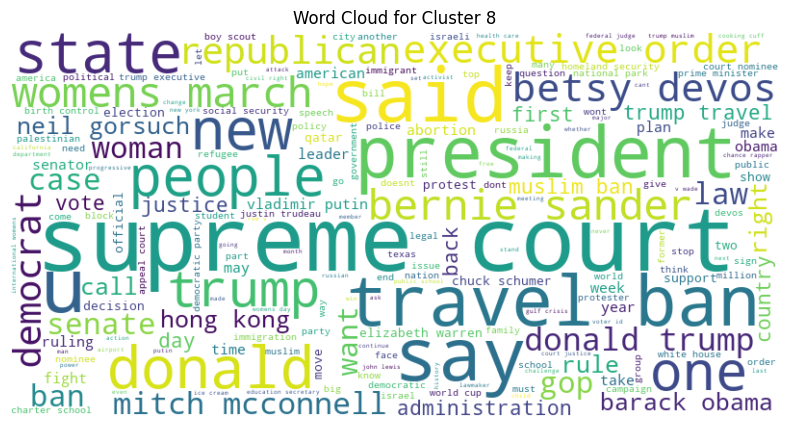

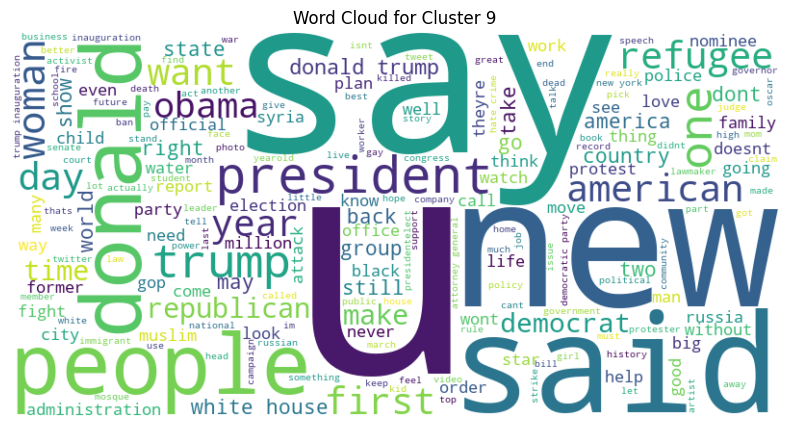

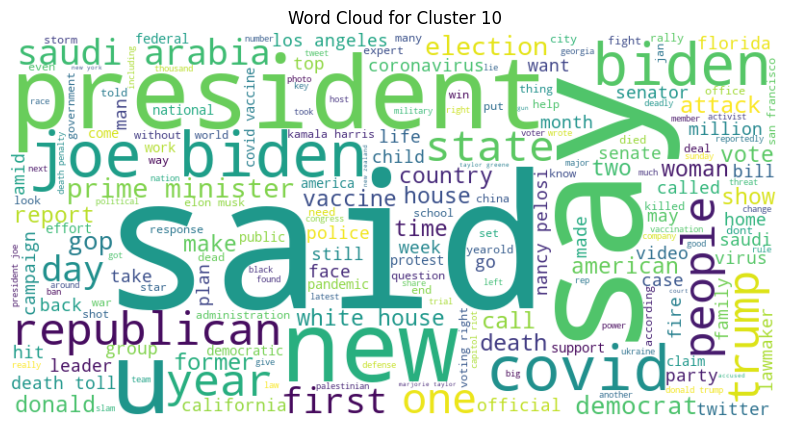

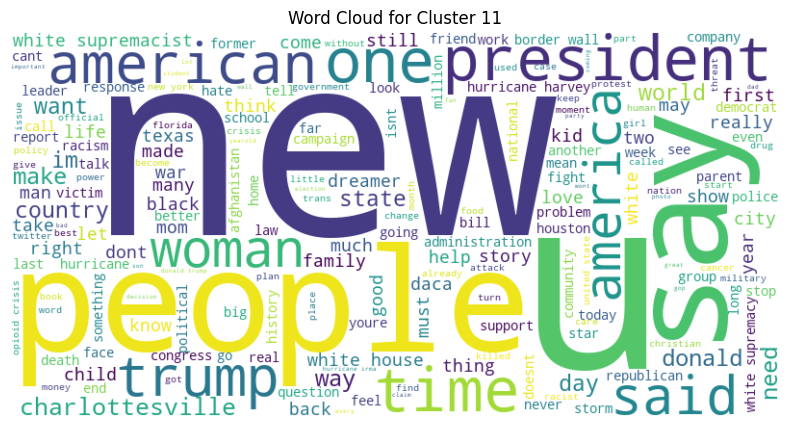

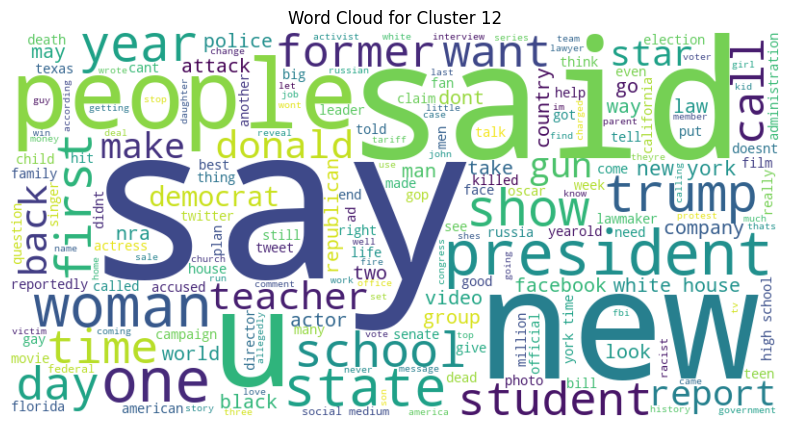

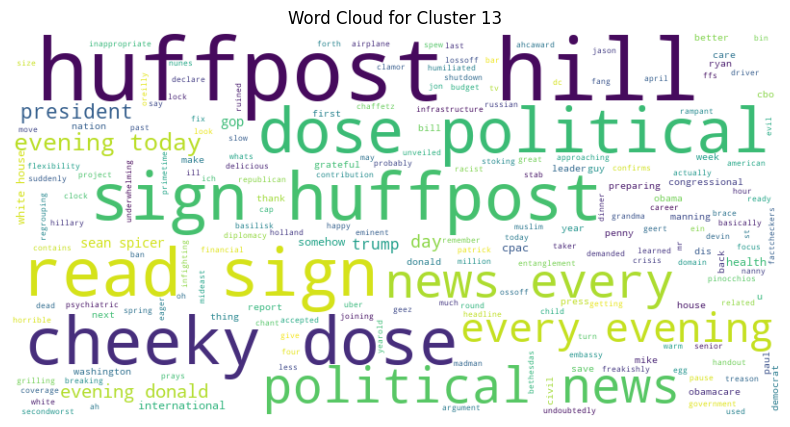

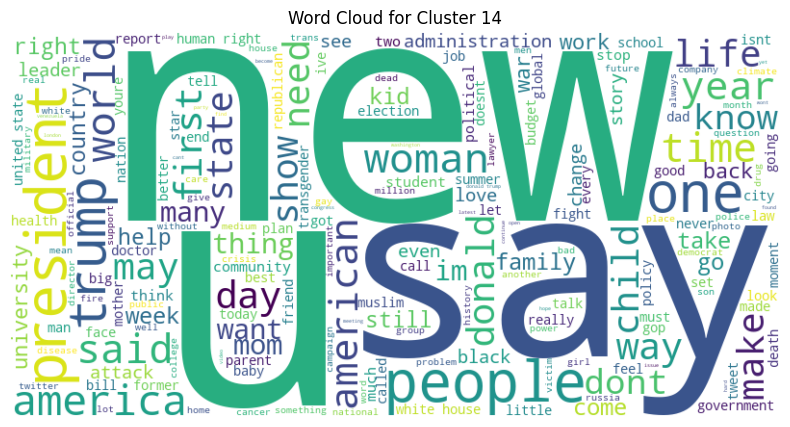

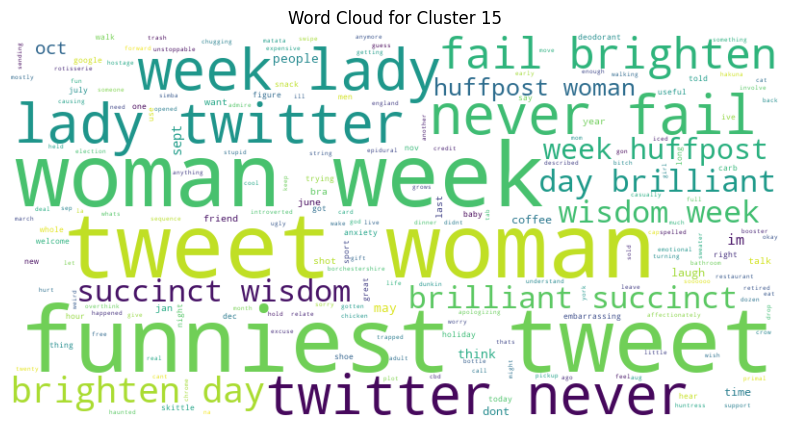

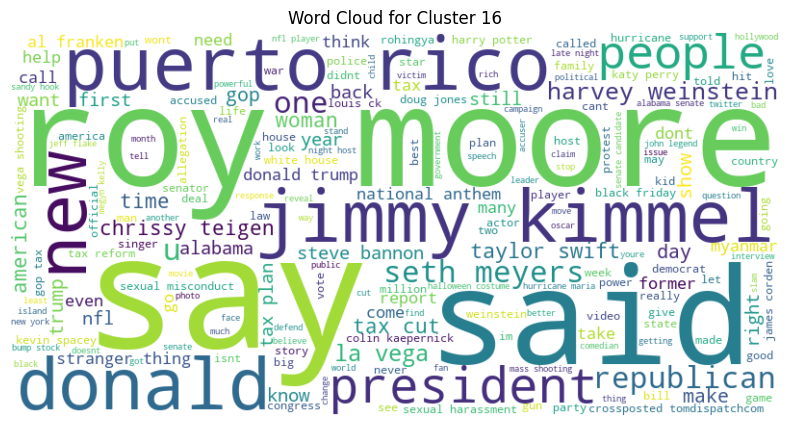

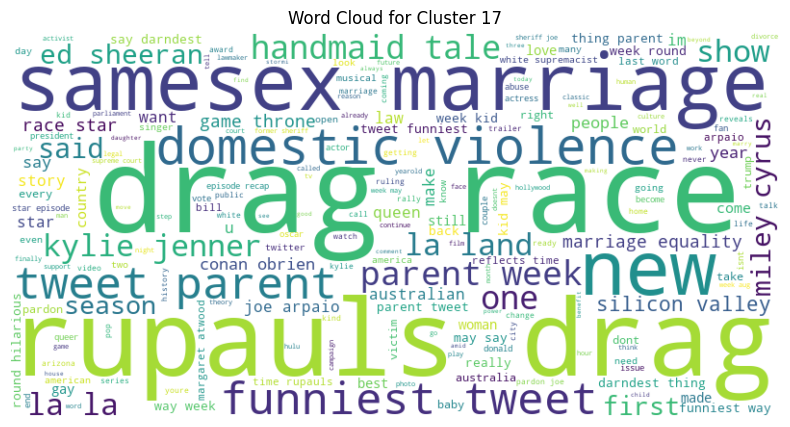

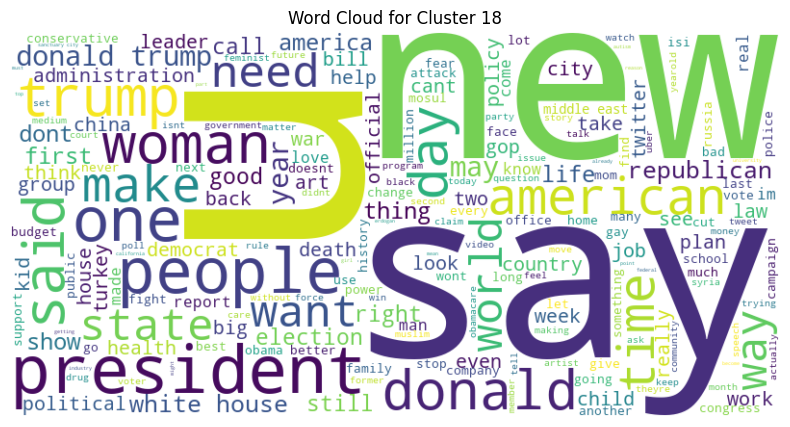

In [12]:
# Function to Generate Word Cloud for Each Cluster
def generate_wordcloud(df, cluster_labels, cluster_number):
    cluster_texts = df[cluster_labels == cluster_number]['filtered_text']
    combined_text = ' '.join(cluster_texts)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster_number}')
    plt.show()

# Generate Word Clouds for Each Cluster in the best k
for cluster_num in range(best_k):
    generate_wordcloud(df, gmm_labels[best_k], cluster_num)


In [ ]:
num_clusters = 19
gmm = GaussianMixture(n_components=num_clusters, covariance_type='full', random_state=42)
labels_gmm = gmm.fit_predict(X_normalized)
df['cluster_gmm'] = labels_gmm

gmm_metrics = {
    'silhouette': silhouette_score(X_normalized, labels_gmm),
    'davies_bouldin': davies_bouldin_score(X_normalized, labels_gmm),
    'calinski_harabasz': calinski_harabasz_score(X_normalized, labels_gmm),
    'similarity': np.mean(cosine_similarity(X_normalized[:1000]))
}

print("GMM Clustering Metrics:")
for key, value in gmm_metrics.items():
    print(f"{key}: {value:.4f}")

GMM Clustering Metrics:
silhouette: 0.3254
davies_bouldin: 0.7525
calinski_harabasz: 27849.3886
similarity: 0.4855
